In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helpers.datasets import *

In [2]:
old_herwig_samps = "/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_features.h5"
new_herwig_samps = "/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_extra_inneronly_features.h5"



In [3]:
def get_lhco_loc(filepath):
    
    print(filepath)
    df = pd.read_hdf(filepath)
    # make_slim(df, directory, lhco_filename)

    # Reorder the features such that the jets are ordered according to their invariant masses
    jet_order_mask = df['mj1'] < df['mj2']
    inverted_keys = ['pxj2', 'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'pxj1', 'pyj1', 'pzj1', 'mj1',
                     'tau1j1', 'tau2j1', 'tau3j1']
    proper_order = df.loc[jet_order_mask]
    improper_order = df.loc[~jet_order_mask]
    improper_order.columns = inverted_keys
    df = pd.concat((proper_order, improper_order))

    for jet in ['j1', 'j2']:
        df[f'pt{jet}'] = np.sqrt(df[f'px{jet}'] ** 2 + df[f'py{jet}'] ** 2)
        df[f'eta{jet}'] = np.arcsinh(df[f'pz{jet}'] / df[f'pt{jet}'])
        df[f'phi{jet}'] = np.arctan2(df[f'py{jet}'], df[f'px{jet}'])
        df[f'p{jet}'] = np.sqrt(df[f'pz{jet}'] ** 2 + df[f'pt{jet}'] ** 2)
        df[f'e{jet}'] = np.sqrt(df[f'm{jet}'] ** 2 + df[f'p{jet}'] ** 2)

    data = df[['mj1', 'mj2']].copy()
    data['mj2-mj1'] = data['mj2'] - data['mj1']
    data[r'$\tau_{21}^{j_1}$'] = df['tau2j1'] / df['tau1j1']
    data[r'$\tau_{32}^{j_1}$'] = df['tau3j1'] / df['tau2j1']
    data[r'$\tau_{21}^{j_2}$'] = df['tau2j2'] / df['tau1j2']
    data[r'$\tau_{32}^{j_2}$'] = df['tau3j2'] / df['tau2j2']
    # data = pd.DataFrame()
    data[r'$p_t^{j_1}$'] = df['ptj1']
    data[r'$p_t^{j_2}$'] = df['ptj2']
    phi_1 = df['phij1']
    phi_2 = df['phij2']
    delPhi = np.arctan2(np.sin(phi_1 - phi_2), np.cos(phi_1 - phi_2))
    data[r'$dR_{jj}$'] = ((df['etaj1'] - df['etaj2']) ** 2 + delPhi ** 2) ** (0.5)

    data['delPhi'] = abs(delPhi)
    data['delEta'] = abs(df['etaj1'] - df['etaj2'])

    data['mjj'] = calculate_mass(
        np.sum([df[[f'ej{i}', f'pxj{i}', f'pyj{i}', f'pzj{i}']].to_numpy() for i in range(1, 3)], 0))
    return data.dropna()

In [4]:
df_old_herwig = get_lhco_loc(old_herwig_samps)
data_old_herwig = select_lhco_features(df_old_herwig, feature_type = 0).to_numpy()

df_new_herwig = get_lhco_loc(new_herwig_samps)
data_new_herwig = select_lhco_features(df_new_herwig, feature_type = 0).to_numpy()

/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_features.h5
/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_extra_inneronly_features.h5


In [5]:
print(data_old_herwig.shape)
print(data_new_herwig.shape)


# pull the old herwig data from sr


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}

def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, 5] >= mass_range[0]) & (dataset[:, 5] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)
        
        
        return selected_data

in_range_old_herwig = pull_from_mass_range(data_old_herwig, [bands_dict["sr"]])

print(in_range_old_herwig.shape)

(999986, 6)
(1044782, 6)
(121978, 6)


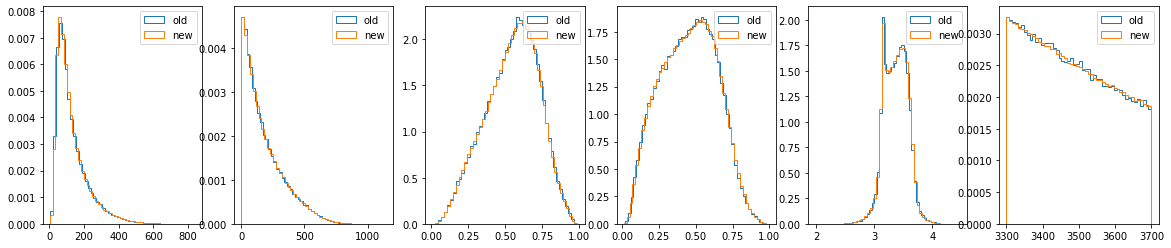

In [6]:


fig, ax = plt.subplots(1, 6, figsize = (20, 4))

bins = 50

for i in range(6):

    ax[i].hist(in_range_old_herwig[:,i], bins, label = "old", histtype = "step", density = True)
    ax[i].hist(data_new_herwig[:,i], bins, label = "new", histtype = "step", density = True)
    
    ax[i].legend()

fig.show()





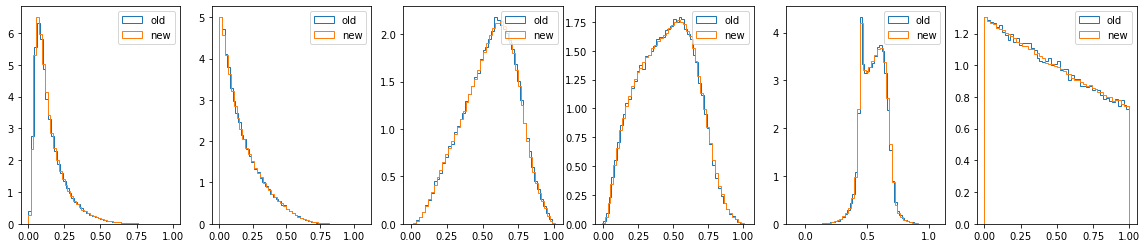

In [7]:
# preprocess

from sklearn.preprocessing import MinMaxScaler

my_scaler = MinMaxScaler().fit(in_range_old_herwig)
    
scaled_old_samps = my_scaler.transform(in_range_old_herwig)
scaled_new_samps = my_scaler.transform(data_new_herwig)
    
    
fig, ax = plt.subplots(1, 6, figsize = (20, 4))

bins = 50

for i in range(6):

    ax[i].hist(scaled_old_samps[:,i], bins, label = "old", histtype = "step", density = True)
    ax[i].hist(scaled_new_samps[:,i], bins, label = "new", histtype = "step", density = True)
    
    ax[i].legend()

fig.show()


    


# Train a BC to discriminate old from new

In [8]:
def ghhghg(train_samp_1, train_samp_2,
                           n_features, n_epochs, batch_size, lr, patience, device, 
                           update_epochs = 1, early_stop = True, visualize = True, seed = None):
    
    
    # save the best model
    val_loss_to_beat = 10000
    best_epoch = -1
    
    
    if seed is not None:
        #print(f"Using seed {seed}...")
        torch.manual_seed(seed)
        np.random.seed(seed)
            
    dense_net = NeuralNet(input_shape = n_features)
    criterion = F.binary_cross_entropy
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)

    dense_net.to(device)
    
    if early_stop:
        early_stopping = EarlyStopping(patience=patience)
    
    # make the input and output data
    nn_train_data = np.concatenate((train_samp_1, train_samp_2))
    nn_train_labs = np.concatenate((torch.zeros((train_samp_1.shape[0], 1)), torch.ones((train_samp_2.shape[0],1))))

    # get weights in case we're oversampling
    class_weights = class_weight.compute_class_weight('balanced', np.unique(nn_train_labs.reshape(-1)), nn_train_labs.reshape(-1))
    class_weights = dict(enumerate(class_weights))
    print(class_weights)
    
    # train-test split
    val_size = 0.2
    
    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(nn_train_data, nn_train_labs, test_size=val_size)
    
    print("Train data, labels shape:", X_train.shape, y_train.shape)
    print("Val data, labels shape:", X_val.shape, y_val.shape)
   
    # send to device
    X_train = np_to_torch(X_train, device)
    X_val = np_to_torch(X_val, device)
    y_train = np_to_torch(y_train, device)
    y_val = np_to_torch(y_val, device)

    epochs, epochs_val = [], []
    losses, losses_val = [], []

    for epoch in tqdm(range(n_epochs)):
        # batching
        indices_list = torch.split( torch.randperm( X_train.shape[0] ), batch_size )
        # initialise lists to store batch stats
        losses_batch_per_e = []
        
        for i, indices in enumerate( indices_list ): # going through the batches
            # calculate the loss, backpropagate
            optimizer.zero_grad()
            
            batch_data = X_train[indices]
            batch_labels = y_train[indices]
            
            # get the weights
            batch_weights = (torch.ones(batch_labels.shape, device=device)
                        - batch_labels)*class_weights[0] \
                        + batch_labels*class_weights[1]

            
            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))
        
        # validation
        if epoch % update_epochs == 0:
            
            with torch.no_grad():
                # batching
                val_indices_list = torch.split( torch.randperm( X_val.shape[0] ), batch_size )
                # initialise lists to store batch stats
                val_losses_batch_per_e = []

                for i, indices in enumerate( val_indices_list ): # going through the batches
                    # calculate the loss, backpropagate
                    optimizer.zero_grad()
                    
                    batch_data = X_val[indices]
                    batch_labels = y_val[indices]

                    # get the weights
                    batch_weights = (torch.ones(batch_labels.shape, device=device)
                                - batch_labels)*class_weights[0] \
                                + batch_labels*class_weights[1]

                    
                    val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 

                    val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

            epochs_val.append(epoch)
            losses_val.append(np.mean(val_losses_batch_per_e))
            
        
            if early_stop:
                early_stopping(np.mean(val_losses_batch_per_e))
                
        if early_stopping.early_stop:
            break

    print("Done training!")
    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(epochs, losses)
        ax.plot(epochs_val, losses_val, label = "val")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        fig.show()


Using device: cuda


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 4.782665726606437, 1: 0.5583748571472327}
Train data, labels shape: (933408, 6) (933408, 1)
Val data, labels shape: (233352, 6) (233352, 1)


 35%|███▌      | 35/100 [09:31<17:40, 16.32s/it]

Done training!


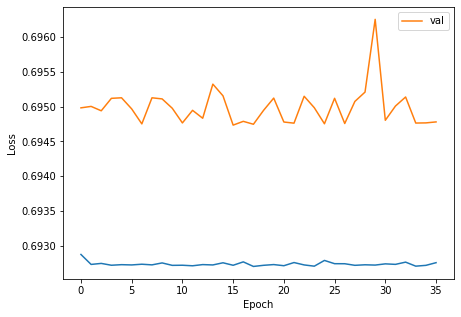

In [9]:
epochs_NN =  100
batch_size_NN = 128
lr_NN = 0.001
patience_NN = 20

import torch
from numba import cuda 

from helpers.composite_helpers import *

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)


roc = ghhghg(scaled_old_samps, scaled_new_samps,
             6, epochs_NN, batch_size_NN, lr_NN, patience_NN, device,
             visualize = True)
